Load the scripts for predicting using the ConvNet model

In [1]:
from os import getcwd, path
import matplotlib.pyplot as plt
import numpy as np

BASE_PATH = getcwd()

DATA_UTILS = path.join(BASE_PATH, 'data_utils.py')
CONV_MODEL = path.join(BASE_PATH, 'convnet/predict.py')
DATA_UTILS = path.join(BASE_PATH, 'data_utils.py')

exec(open(DATA_UTILS).read())
exec(open(CONV_MODEL).read())
exec(open(DATA_UTILS).read())

/home/2359media/miniconda3/envs/botbot-nlp/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Load files necessary for inference to cache

In [2]:
MODEL_PATH = path.join(BASE_PATH, 'convnet/model/model.h5')
TOKENIZER_PATH = path.join(BASE_PATH, 'convnet/model/tokenizer.pickle')
CLASSES_PATH = path.join(BASE_PATH, 'convnet/model/classes.json')

model = load_saved_model(MODEL_PATH, ignore_cache=True)
tokenizer = load_tokenizer(TOKENIZER_PATH, ignore_cache=True)
classes = load_classes(CLASSES_PATH, ignore_cache=True)

Test the loaded model:
- run_predict() returns a matrix of prediction results, accepts a list of texts or a singular string
- interpret_netout() is a generator which loops through the results and return a tuple of class name and probability

In [3]:
next(interpret_netout(run_predict('My baby has a fever')))

('Baby Care - Baby Conditions - Colic - Diff', 70.63592672348022)

Try to run samples through the model to see false evaluations
This will help isolate the examples that make the model confused

In [4]:
TRAIN_PATH = path.join(BASE_PATH, 'kc_data.json')
X_data, y_data = get_data_pairs(data_from_json(TRAIN_PATH))

result = list(interpret_netout(run_predict(X_data)))

cell_text = []
for (idx, (result_class, proba)) in list(enumerate(result)):
    if y_data[idx] != result_class:
        cell_text.append([X_data[idx], y_data[idx], result_class, proba])

Found 627 (accuracy: 93.89) misassigned examples. Showing the top 40


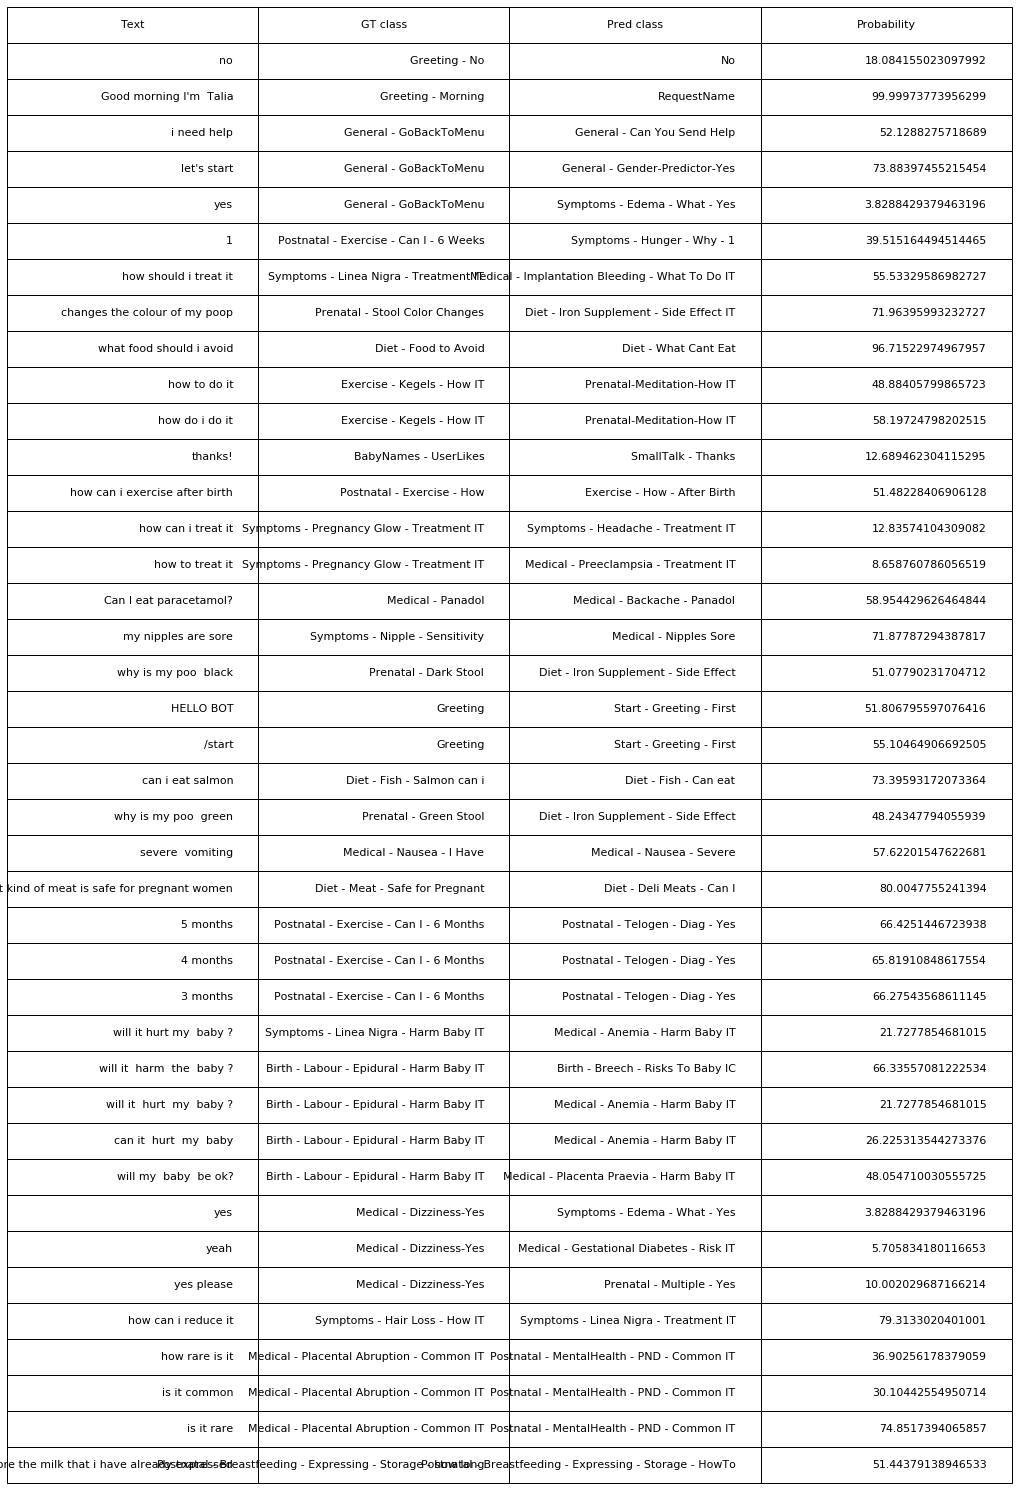

In [5]:
import matplotlib.pyplot as plt

print('Found %s (accuracy: %s) misassigned examples. Showing the top 40' \
    % (len(cell_text), 100 - round(len(cell_text) / len(X_data) * 100, 2)))

if len(cell_text) > 0:
    table = plt.table(cellText=cell_text[:40],
              colLabels=['Text', 'GT class', 'Pred class', 'Probability'],
              loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(11)
    table.scale(3,3)
    plt.axis('off')
    plt.show()

Visualize attention map

In [21]:
from keras.models import Model
from keras import backend as K
import matplotlib.pyplot as plt

def get_attention_layers(model):
    attention_layers = []
    for layer in model.layers:
        if 'attention_vec' in layer.name and '_dim_reduction' not in layer.name:
            attention_layers.append(layer)
    return attention_layers

def get_attention_output(text, model):
    attention_layers = get_attention_layers(model)
    if len(attention_layers) == 0:
        print('This model does not implement attention mechanism')
        return
    
    class_weights = model.layers[-1].get_weights()[0]
    X_tokens, X_pos = get_inputs([text], tokenizer)
    
    inputs = text.split(' ')
    
    for layer in attention_layers:
        get_output = K.function(model.input + [K.learning_phase()], [layer.output])
        attentions = get_output([X_tokens, X_pos])[0]
        
        yield layer.name, inputs, attentions
        
def visualize_attention(activations, inputs):
    output_length = activations.shape[1] - len(inputs)
    plt.imshow(activations[0, output_length:], interpolation='None', cmap='jet', aspect='auto')
    plt.show()

('Prenatal - Maternity Clothes - Jeans', 45.34350335597992)
Attention output for: static_attention_vec
(1, 512, 300)


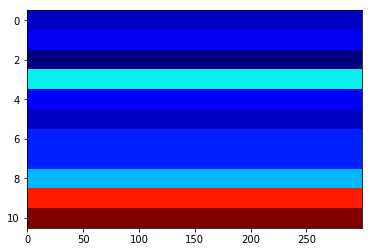

Attention output for: non_static_attention_vec
(1, 512, 300)


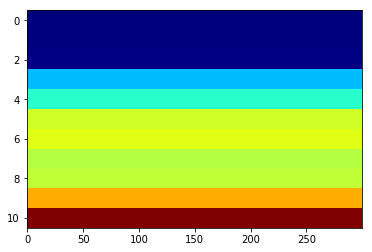

Attention output for: pos_attention_vec
(1, 512, 46)


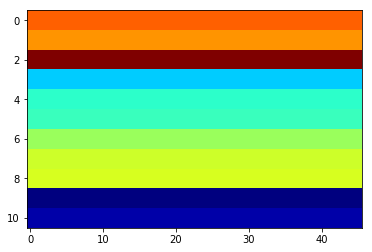

In [27]:
test_text = 'why is my poop green? what should I do with it?'
print(next(interpret_netout(run_predict(test_text))))
for layer_name, inputs, attentions in get_attention_output(test_text, model):
    print('Attention output for: %s' % layer_name)
    print(attentions.shape)
    visualize_attention(attentions, inputs)